In [2]:
import numpy as np
import lbg_forecast.nz as nz
import matplotlib.pyplot as plt
import scipy as sc

array([[0.71236229],
       [0.01209259],
       [1.06319809],
       ...,
       [0.0893364 ],
       [0.04097366],
       [0.0358696 ]])

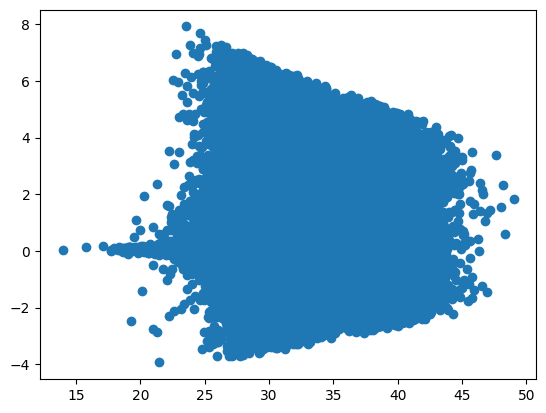

In [3]:
run='hpcsmall'
photometry = np.load("photo_samples/photo_"+run+".npy", allow_pickle=True)

run='hpcsmallcpu'
photometry0 = np.load("photo_samples/photo_"+run+".npy", allow_pickle=True)

real = 0
plt.scatter(photometry0[real], (photometry[real] - photometry0[real])/(photometry0[real])*100)

photometry[real] - photometry0[real]


(array([3.0000e+00, 1.6000e+01, 7.0000e+01, 3.1300e+02, 1.7280e+03,
        5.7010e+03, 1.0791e+04, 1.6661e+04, 1.8436e+04, 1.4712e+04,
        9.5540e+03, 7.2820e+03, 6.8720e+03, 4.9790e+03, 2.1940e+03,
        5.3200e+02, 1.2000e+02, 2.5000e+01, 7.0000e+00]),
 array([15.        , 16.84210526, 18.68421053, 20.52631579, 22.36842105,
        24.21052632, 26.05263158, 27.89473684, 29.73684211, 31.57894737,
        33.42105263, 35.26315789, 37.10526316, 38.94736842, 40.78947368,
        42.63157895, 44.47368421, 46.31578947, 48.15789474, 50.        ]),
 <BarContainer object of 19 artists>)

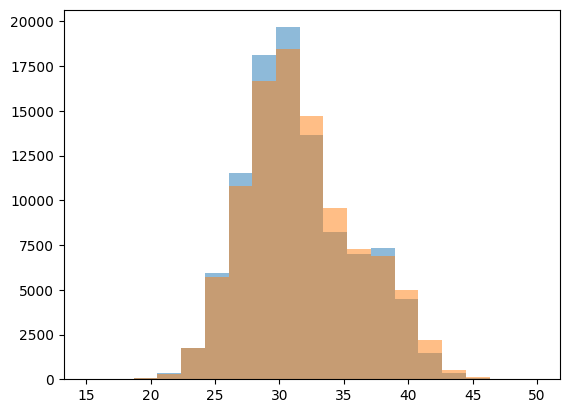

In [52]:
real = 7
bins = np.linspace(15, 50, 20)
plt.hist(photometry0[real], bins=bins, alpha=0.5)
plt.hist(photometry[real], bins=bins, alpha=0.5)

(array([1.50000e+01, 9.90000e+01, 4.37000e+02, 2.35400e+03, 1.21150e+04,
        4.07220e+04, 7.89640e+04, 1.24166e+05, 1.46635e+05, 1.22276e+05,
        8.12850e+04, 6.22440e+04, 5.86610e+04, 4.40990e+04, 1.97190e+04,
        4.93100e+03, 1.02900e+03, 1.86000e+02, 4.40000e+01]),
 array([15.        , 16.84210526, 18.68421053, 20.52631579, 22.36842105,
        24.21052632, 26.05263158, 27.89473684, 29.73684211, 31.57894737,
        33.42105263, 35.26315789, 37.10526316, 38.94736842, 40.78947368,
        42.63157895, 44.47368421, 46.31578947, 48.15789474, 50.        ]),
 <BarContainer object of 19 artists>)

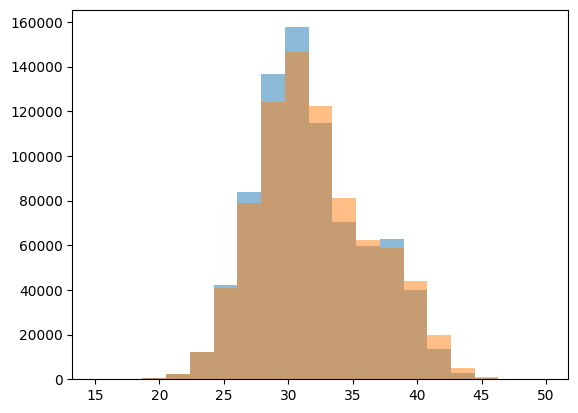

In [53]:

bins = np.linspace(15, 50, 20)
photometry_collapsed0 = np.squeeze(photometry0, axis=2).ravel()
plt.hist(photometry_collapsed0, bins=bins, alpha=0.5)
photometry_collapsed = np.squeeze(photometry, axis=2).ravel()
plt.hist(photometry_collapsed, bins=bins, alpha=0.5)

In [3]:
run='hpc4'
nzs = np.load("nz_samples/nz_"+run+".npy", allow_pickle=True)

print(nzs.shape)

(8, 3)


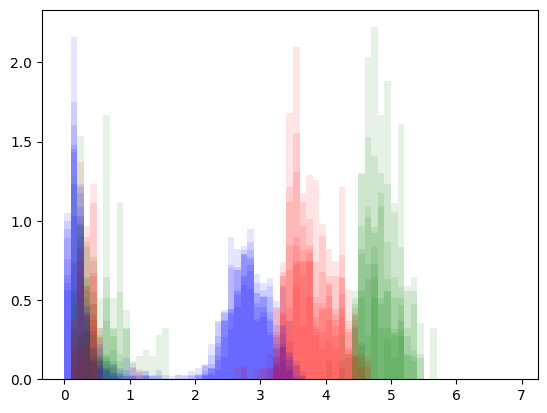

In [4]:
bins = nz.default_nz_bins()

for n in range(nzs.shape[0]):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

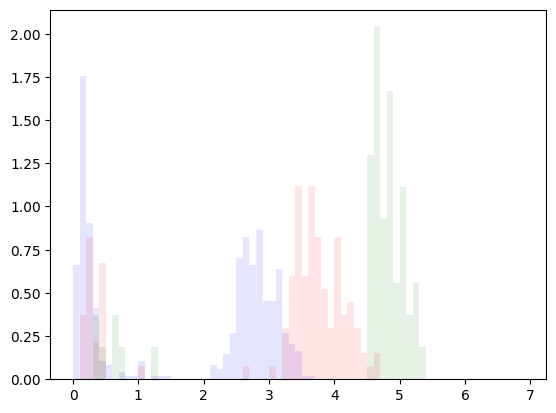

In [5]:
indx=np.random.randint(0, nzs.shape[0])
hist = plt.hist(nzs[indx][0], density=True, bins=bins, alpha = 0.1, color='blue')
hist = plt.hist(nzs[indx][1], density=True, bins=bins, alpha = 0.1, color='red')
hist = plt.hist(nzs[indx][2], density=True, bins=bins, alpha = 0.1, color='green')

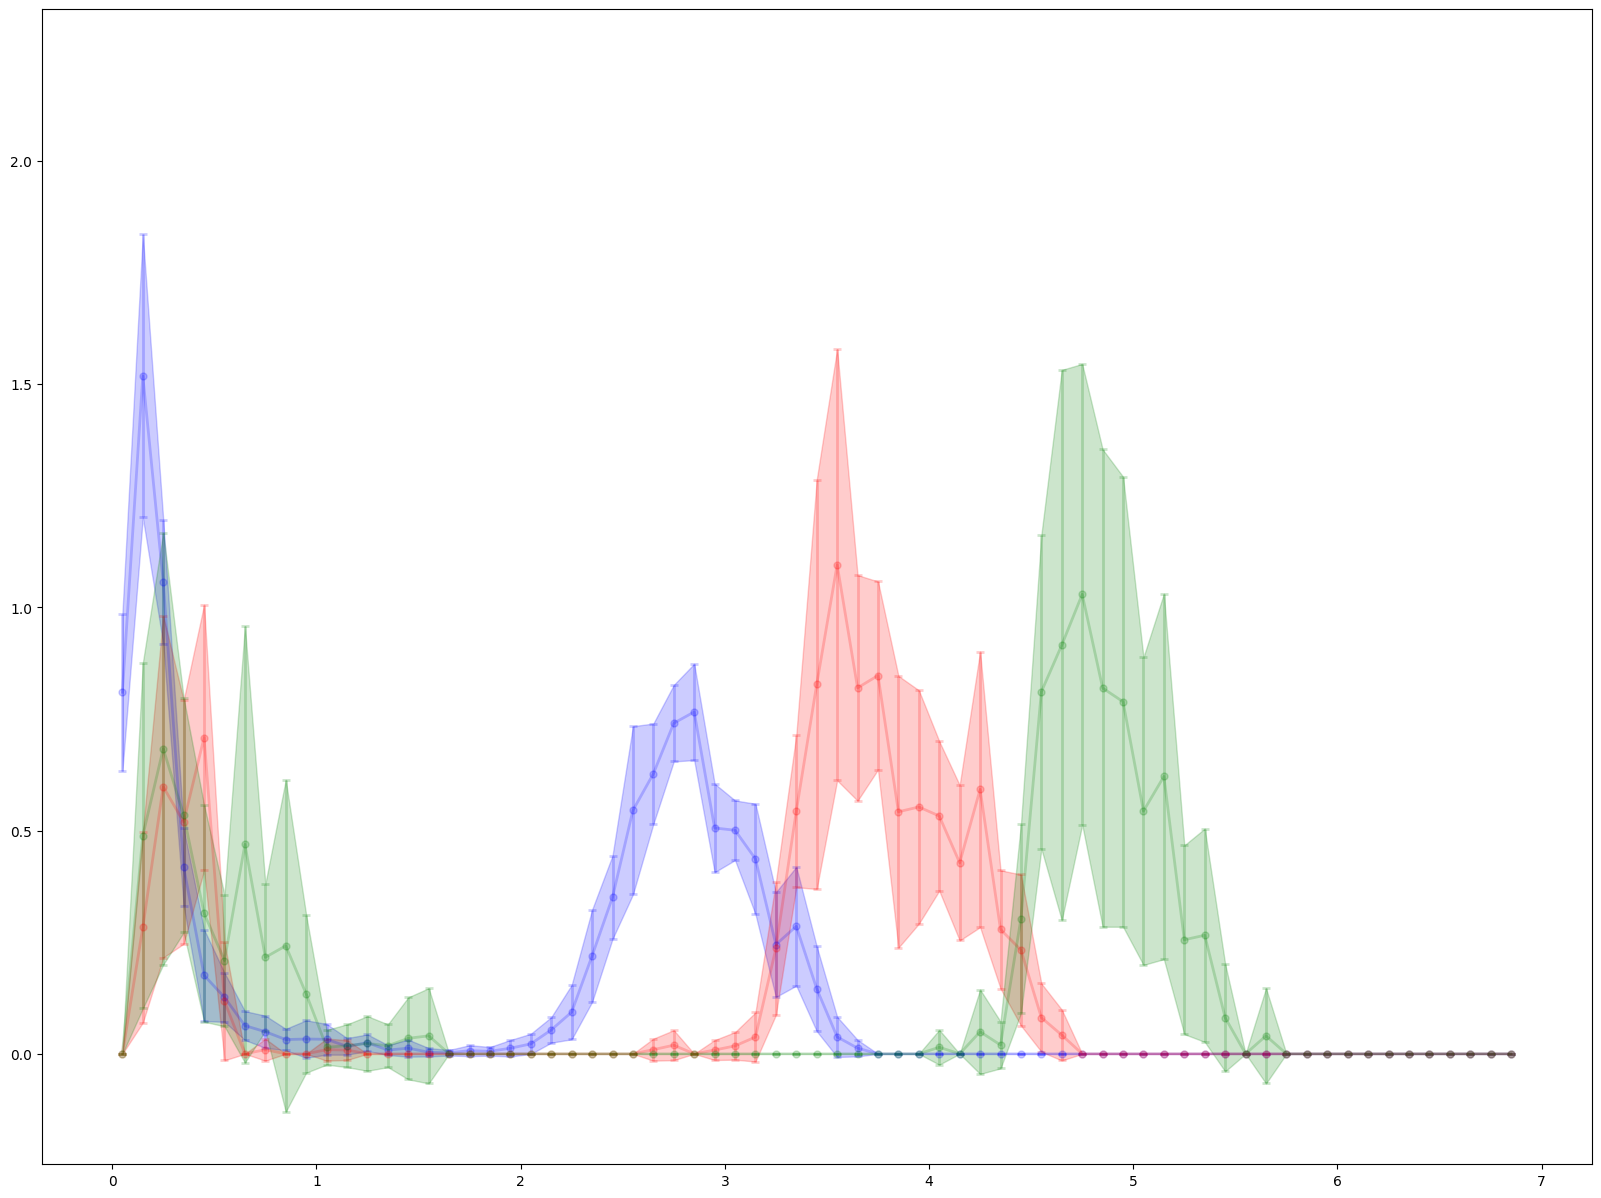

In [6]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for n in range(nzs.shape[0]):
        hist = axes.hist(nzs[n][drop], density=True, bins=bins, alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

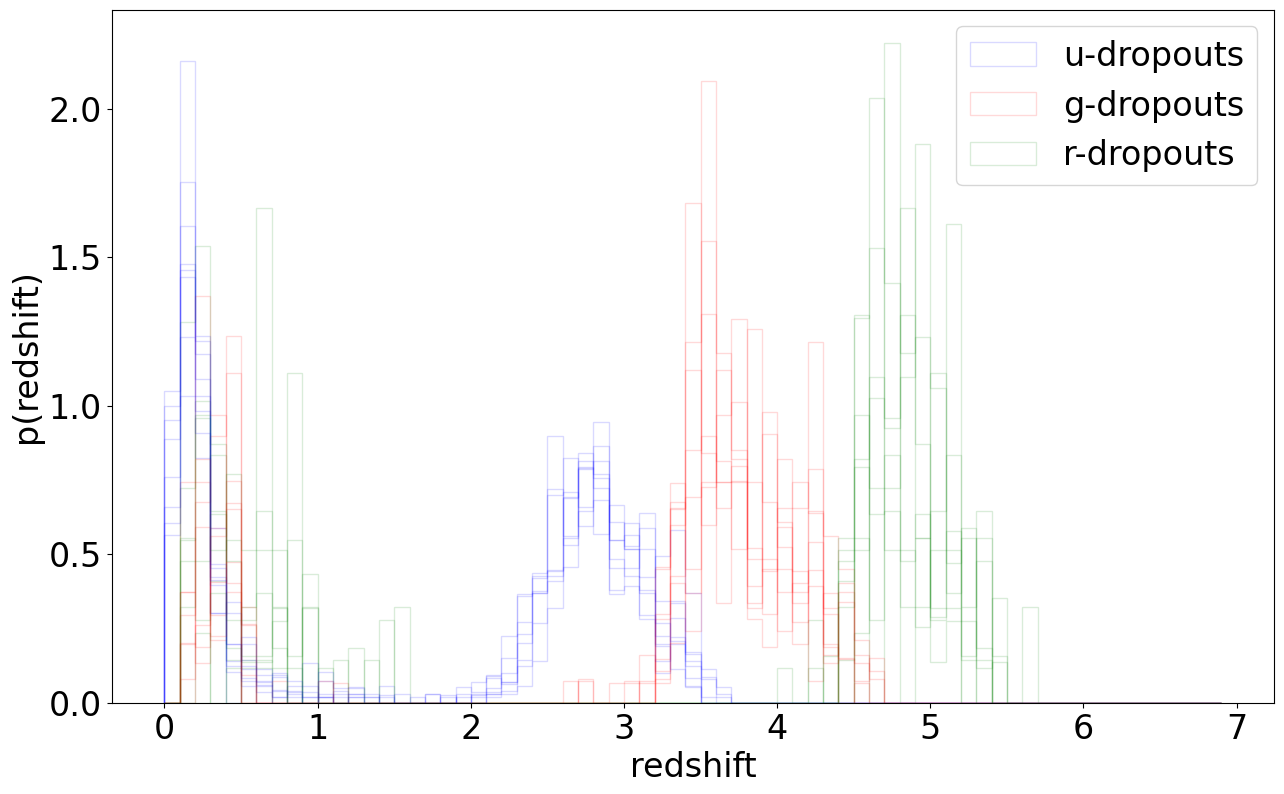

In [7]:
colours = ['blue', 'red', 'green']
labels = ['u-dropouts', "g-dropouts", "r-dropouts"]
ndropouts=3
f, ax = plt.subplots(1, 1, figsize=(15, 9))
for ind in range(nzs.shape[0]):
    for drop in range(ndropouts):
        if(ind == 0):
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step', label=labels[drop])
        else:
            hist = plt.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.15, color=colours[drop], histtype='step')
plt.legend(fontsize=24)
plt.xlabel("redshift", fontsize=24)
plt.ylabel("p(redshift)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)

(0.0, 2.5)

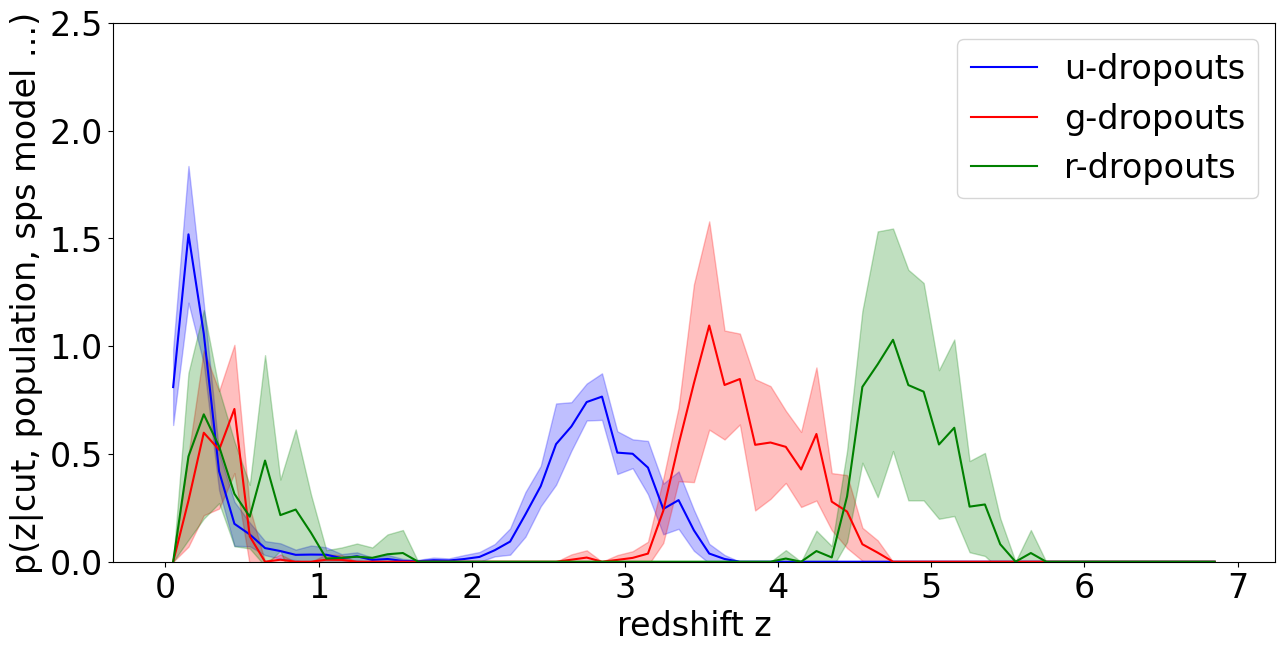

In [8]:
fig1, axes = plt.subplots(1, 1, figsize=(15,7), sharex=False, sharey=False)

for drop in range(ndropouts):

    values = []
    x = []
    for ind in range(nzs.shape[0]):
        hist = axes.hist(nzs[ind][drop], density=True, bins=nz.default_nz_bins(), alpha = 0.001, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=nz.default_nz_bins())
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=nz.default_nz_bins())
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    #axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=10, fmt="o", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop], label=labels[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.25, color=colours[drop])
    axes.plot(bin_centers, bin_means, color=colours[drop], label=labels[drop])

plt.legend(fontsize=24)
plt.xlabel("redshift z", fontsize=24)
plt.ylabel("p(z|cut, population, sps model ...)", fontsize=24)
plt.tick_params('x', labelsize=24)
plt.tick_params('y', labelsize=24)
plt.ylim(0, 2.5)

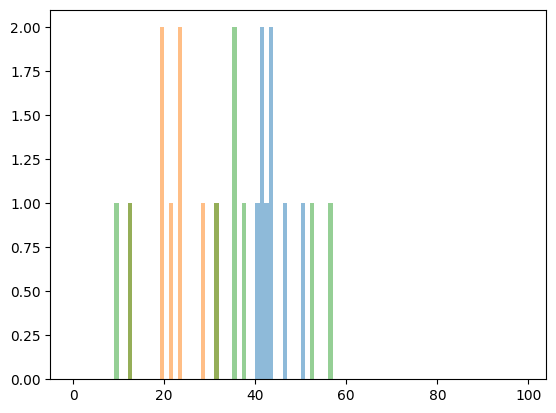

In [9]:
def interlopers(samples):
    nint = len(np.where(samples<1.5)[0])
    ntot = len(samples)
    return (nint/ntot)*100

uints = []
gints = []
rints = []
for n in range(nzs.shape[0]):
    uints.append(interlopers(nzs[n][0]))
    gints.append(interlopers(nzs[n][1]))
    rints.append(interlopers(nzs[n][2]))

nbins = np.arange(0.0, 100, 1)
histogram = plt.hist(uints, alpha=0.5, bins=nbins)
histogram = plt.hist(gints, alpha=0.5, bins=nbins)
histogram = plt.hist(rints, alpha=0.5, bins=nbins)

In [10]:
#np.save("redshifts/emulated_redshifts_0.npy", nzs)